In [52]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.optimize import leastsq


In [59]:
# Don't forget!!! Needed for google collab run but dont include if you're running locally
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

root_dir = "/content/gdrive/MyDrive/"
base_dir = root_dir + 'uni_wien/BIOTIMA/beam_profiling'

Mounted at /content/gdrive


In [66]:
!ls /content/gdrive/MyDrive/uni_wien/BIOTIMA/beam_profiling

beam_profiling.ipynb   m2h_10_2023_11_10.mp4  m2v_01_2023_11_10.mp4  m2v_12_2023_11_10.mp4
m2h_00_2023_11_10.mp4  m2h_11_2023_11_10.mp4  m2v_02_2023_11_10.mp4  m2v_13_2023_11_10.mp4
m2h_01_2023_11_10.mp4  m2h_12_2023_11_10.mp4  m2v_03_2023_11_10.mp4  m2v_14_2023_11_10.mp4
m2h_02_2023_11_10.mp4  m2h_13_2023_11_10.mp4  m2v_04_2023_11_10.mp4
m2h_03_2023_11_10.mp4  m2h_14_2023_11_10.mp4  m2v_10_2023_11_10.mp4
m2h_04_2023_11_10.mp4  m2v_00_2023_11_10.mp4  m2v_11_2023_11_10.mp4


In [ ]:
# Running locally
# base_dir = ''

In [54]:
import cv2

cap = cv2.VideoCapture("m2v_00_2023_11_10.mp4")


In [ ]:
ret, frame = cap.read()

### This is generally what our data look like

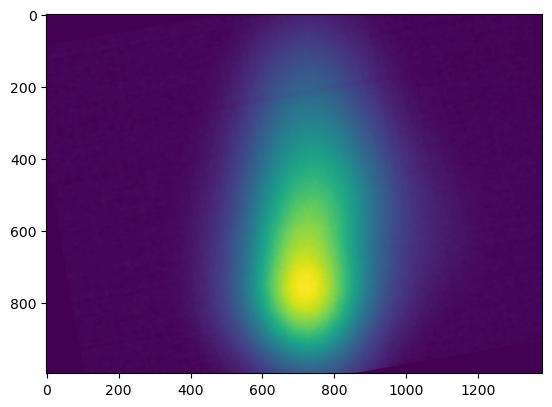

In [ ]:
rotation_angle = 10
subset_correction_vert = 200
subset_correction_horz = 350
corrected_frame_container = []
plt.imshow(sp.ndimage.rotate(np.sum(frame,axis=2),10)[subset_correction_vert:-subset_correction_vert,subset_correction_horz:-subset_correction_horz])

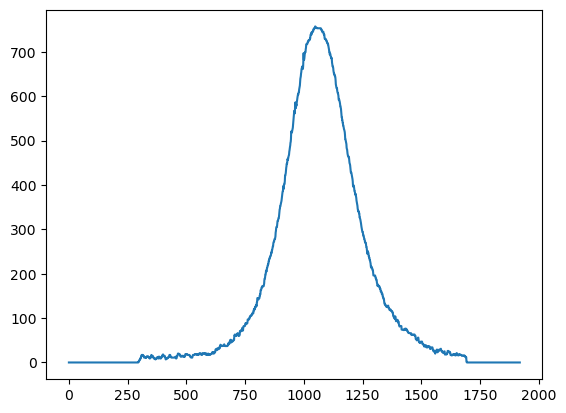

In [ ]:
plt.plot(np.sum(frame,axis=2)[np.argmax(np.mean(np.mean(frame,axis=2),axis=1))])

In [3]:
from math import pi
pixel_width = 2.4e-6 # pixel width in horizontal(1920) direction
_lambda = 337e-9 # wavelength of beam

def waist_profile(M,w_0,x):
    return w_0*(M**2+M**2*(_lambda*x/(pi*(w_0)**2))**2)**.5

def waist_profile_residual(p,x,t):
    M,w_0 = p
    sim = waist_profile(M,w_0,x)
    return t-sim

def gaussian(A_0,w,x_0,x):
    return A_0*np.exp(-2*(x-x_0)**2/(w**2))

def gaussian_residual(p,x,t):
    A_0,w,x_0 = p
    sim = gaussian(A_0,w,x_0,x)
    return t-sim

### Symmetric Fitting procedure
This is important for understanding

[1.00026147e+00 2.97735954e-06]


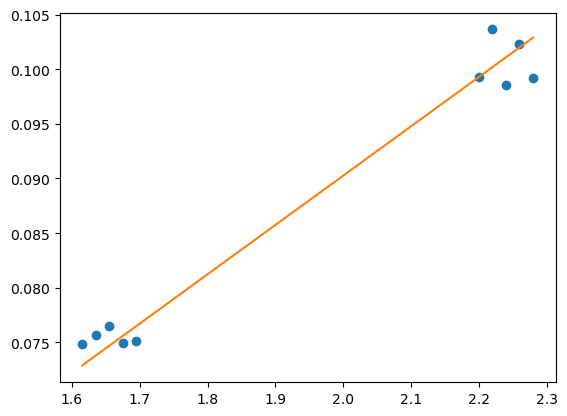

In [ ]:


waist_container = []
x_proj_profile_container = []
x = [1.615, 1.635, 1.655, 1.675, 1.695, 2.2, 2.22, 2.24, 2.26, 2.28]
for i in range(2):
    for j in range(5):
        cap = cv2.VideoCapture("m2_"+str(i)+str(j)+".mp4")
        ret, frame = cap.read()
        x_proj = np.sum(np.sum(frame,axis=2),axis=1)
        max_index = np.argmax(x_proj)
        target_gauss = np.sum(frame,axis=2)[max_index]
        p_0_gauss = np.ones(2)
        l = np.arange(1920)*pixel_width
        pfit_gauss, pcov_gauss = leastsq(gaussian_residual,p_0_gauss, args=(l,target_gauss),full_output=1)[:2]
        waist_container.append(pfit_gauss[0])

target_waist = np.abs(waist_container)
p_0_waist = np.array([1,1e-6])
pfit_waist,pcov_waist = leastsq(waist_profile_residual,p_0_waist,args=(np.array(x),target_waist),full_output=1)[:2]
print(pfit_waist)
plt.plot(x,target_waist,'o')
plt.plot(x,waist_profile(*pfit_waist,np.array(x))) #[0]*np.ones(len(x)),pfit_waist[1]*np.ones(len(x))

### Astigmatic fitting procedure

In [2]:
pixel_width_h = 2.4e-6
pixel_width_v = 3.4e-6

In [71]:
def frame_grab(frame_index, date, astigmatic = True, correction = True, rotation_angle = 10):
    # astigmatic for if we want to use this on a simpler symmetric beam
    try :
        subset_correction_vert = 200
        subset_correction_horz = 350

        corrected_vframe_container =  np.zeros((2,5,997,1378))
        corrected_hframe_container = np.zeros((2,5,997,1378))
        for i in range(2):
            for j in range(5):
                cap = cv2.VideoCapture(base_dir+'/m2v_'+ str(i) + str(j) + date)
                for k in range(1+frame_index):

                    ret, frame = cap.read()
                #print(str(i)+str(j))

                corrected_vframe_container[i][j] = sp.ndimage.rotate(np.sum(frame,axis=2),rotation_angle)[subset_correction_vert:-subset_correction_vert,subset_correction_horz:-subset_correction_horz]

                cap = cv2.VideoCapture(base_dir+'/m2h_'+ str(i) + str(j) + date)
                for k in range(1+frame_index):
                    ret, frame = cap.read()
                corrected_hframe_container[i][j] = sp.ndimage.rotate(np.sum(frame,axis=2),rotation_angle)[subset_correction_vert:-subset_correction_vert,subset_correction_horz:-subset_correction_horz]

    except UnboundLocalError:
        print('No frames left to read')
    else:
        return corrected_hframe_container, corrected_vframe_container

In [73]:
#Ex test
corrected_hframe_container, corrected_vframe_container = frame_grab(0,'_2023_11_10.mp4')

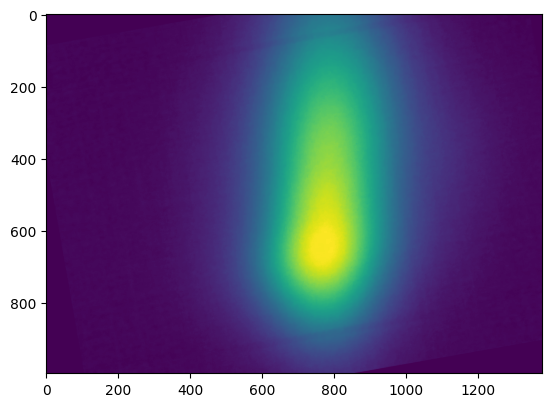

In [74]:
plt.imshow(corrected_hframe_container[0][0])

In [75]:
# Import data from notebook or transcribe
x_h = [2.236,2.231,2.241,2.246,2.251,1.892,1.887,1.882,1.877,1.872]
x_v = [2.471,2.466,2.461,2.456,2.451,2.372,2.377,2.382,2.387,2.392]

In [76]:
def fit_harness(corrected_hframe_container,corrected_vframe_container,x_h,x_v):

    waist_container_h = []
    center_container_h = []
    amplitude_contaner_h = []
    x_h_proj_profile_container = np.zeros((2,5,1378))

    waist_container_v = []
    center_container_v = []
    amplitude_contaner_v = []
    x_v_proj_profile_container =  np.zeros((2,5,997))



    for i in range(2):
        for j in range(5):
            corrected_hframe = corrected_hframe_container[i][j]
            x_proj_h = np.sum(corrected_hframe,axis=1)
            max_index_h = np.argmax(x_proj_h)
            target_gauss_h = corrected_hframe[max_index_h]
            target_gauss_h = target_gauss_h-np.mean(target_gauss_h[target_gauss_h<20])
            p_0_gauss_h = np.array([700,400*pixel_width_h,600*pixel_width_h])
            l_h = np.arange(corrected_hframe.shape[1])*pixel_width_h
            pfit_gauss_h, pcov_gauss_h = leastsq(gaussian_residual,p_0_gauss_h, args=(l_h,target_gauss_h),full_output=1)[:2]
            waist_container_h.append(pfit_gauss_h[1])
            center_container_h.append(pfit_gauss_h[2])
            amplitude_contaner_h.append(pfit_gauss_h[0])

            corrected_vframe = corrected_vframe_container[i][j]
            x_proj_v = np.sum(corrected_vframe,axis=0)
            max_index_v = np.argmax(x_proj_v)
            target_gauss_v = corrected_vframe[:,max_index_v]
            #target_gauss_v = target_gauss_v - np.mean(target_gauss_v[target_gauss_v<20])
            p_0_gauss_v = np.array([700,1000*pixel_width_h,600*pixel_width_h])
            l_v = np.arange(corrected_vframe.shape[0])*pixel_width_v
            pfit_gauss_v, pcov_gauss_v = leastsq(gaussian_residual,p_0_gauss_v, args=(l_v,target_gauss_v),full_output=1)[:2]
            waist_container_v.append(pfit_gauss_v[1])
            center_container_v.append(pfit_gauss_v[2])
            amplitude_contaner_v.append(pfit_gauss_v[0])
    return waist_container_h, center_container_h, amplitude_contaner_h, waist_container_v, center_container_v, amplitude_contaner_v

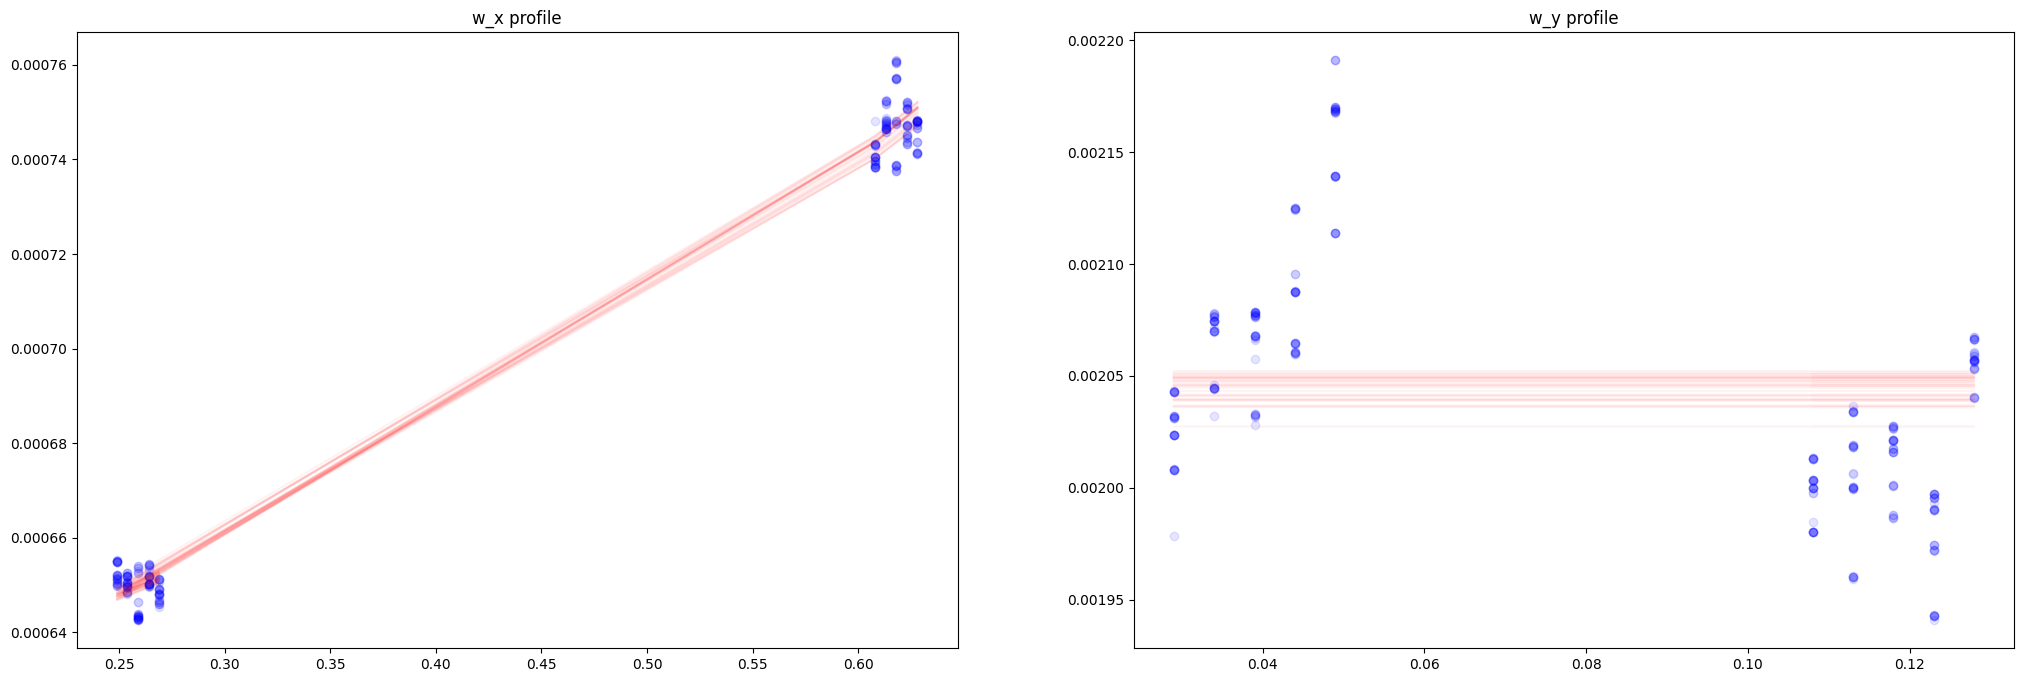

In [ ]:
target_waist_container_h =  []
target_waist_container_v = []
plt.figure(figsize=(25,8))

for k in range(30):
    corrected_hframe_container, corrected_vframe_container = frame_grab(k,'_2023_11_10.mp4')
    waist_container_h, center_container_h, amplitude_contaner_h, waist_container_v, center_container_v, amplitude_contaner_v = fit_harness(corrected_hframe_container,corrected_vframe_container,x_h,x_v)
    #plt.plot(gaussian(amplitude_contaner_h[5*0+i],waist_container_h[5*0+i],center_container_h[5*0+i],l_h),list(mcolors.TABLEAU_COLORS)[5*0+i])
    target_waist_h = np.abs(waist_container_h)
    target_waist_container_h.append(target_waist_h)
    p_0_waist_h = np.array([1,76e-6])
    pfit_waist_h,pcov_waist_h = leastsq(waist_profile_residual,p_0_waist_h,args=(2.5-np.array(x_h),target_waist_h),full_output=1)[:2]

    target_waist_v = np.abs(waist_container_v)
    target_waist_container_v.append(target_waist_v)
    p_0_waist_v = np.array([1,76e-5])
    pfit_waist_v,pcov_waist_v = leastsq(waist_profile_residual,p_0_waist_v,args=(2.5-np.array(x_v),target_waist_v),full_output=1)[:2]

    plt.subplot(1,2,1)
    plt.title("w_x profile")
    plt.plot(2.5-np.array(x_h),target_waist_h,'bo')
    plt.plot(2.5-np.array(x_h),waist_profile(*pfit_waist_h,2.5-np.array(x_h)),'r',alpha=.05)
      #[0]*np.ones(len(x)),pfit_waist[1]*np.ones(len(x))
    plt.subplot(1,2,2)
    plt.title("w_y profile")
    plt.plot(2.5-np.array(x_v),target_waist_v,'bo')
    plt.plot(2.5-np.array(x_v),waist_profile(*pfit_waist_v,2.5-np.array(x_v)),'r',alpha=.05)



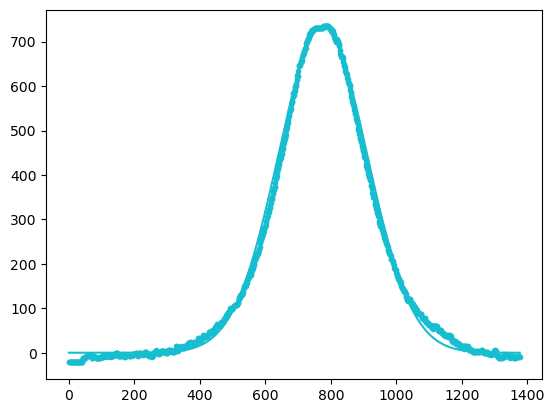

In [ ]:
corrected_hframe = corrected_hframe_container[0][0]
x_proj_h = np.sum(corrected_hframe,axis=1)
max_index_h = np.argmax(x_proj_h)
target_gauss_h = corrected_hframe[max_index_h]# - np.mean(corrected_hframe[max_index_h][:200])
target_gauss_h = target_gauss_h - np.mean(target_gauss_h[target_gauss_h<20])
p_0_gauss_h = np.array([700,.001,.001])
l_h = np.arange(corrected_hframe.shape[1])*pixel_width_h
pfit_gauss_h, pcov_gauss_h = leastsq(gaussian_residual,p_0_gauss_h, args=(l_h,target_gauss_h),full_output=1)[:2]
plt.plot(gaussian(pfit_gauss_h[0],pfit_gauss_h[1],pfit_gauss_h[2],l_h),list(mcolors.TABLEAU_COLORS)[-1])
plt.plot(target_gauss_h-np.mean(corrected_hframe[774][:200]),list(mcolors.TABLEAU_COLORS)[-1],marker='.')


In [ ]:
amplitude_contaner_h

[733.5805774612285,
 726.9314190153797,
 735.3621816538798,
 734.7768742669872,
 739.6187963202801,
 639.6907417006895,
 634.8243631691806,
 624.0399804746635,
 608.0795257800442,
 598.5094265466063]

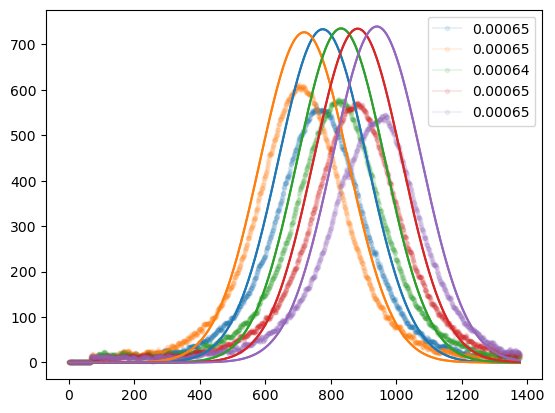

In [ ]:
for i in range(5):
    plt.plot(corrected_hframe_container[0][i][774,:],list(mcolors.TABLEAU_COLORS)[i],marker='.',alpha=.1)
#for i in range(5):
#    plt.plot(corrected_hframe_container[1][i][774,:],list(mcolors.TABLEAU_COLORS)[i+5],marker='.',alpha=.1)
plt.legend([str(np.round(waist,5)) for waist in waist_container_h])
for j in range(2):
    for i in range(5):
        plt.plot(gaussian(amplitude_contaner_h[5*0+i],waist_container_h[5*0+i],center_container_h[5*0+i],l_h),list(mcolors.TABLEAU_COLORS)[5*0+i])

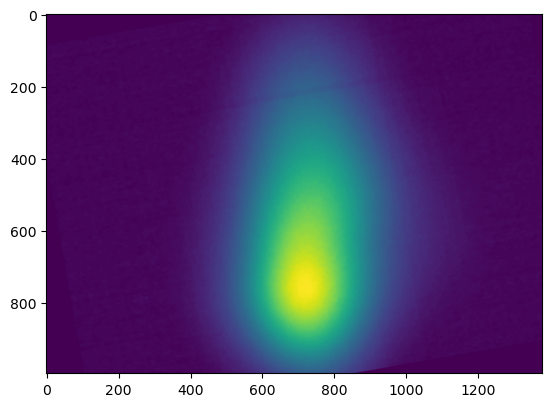

In [ ]:
plt.imshow(corrected_vframe_container[0][0])

IndexError: list index out of range

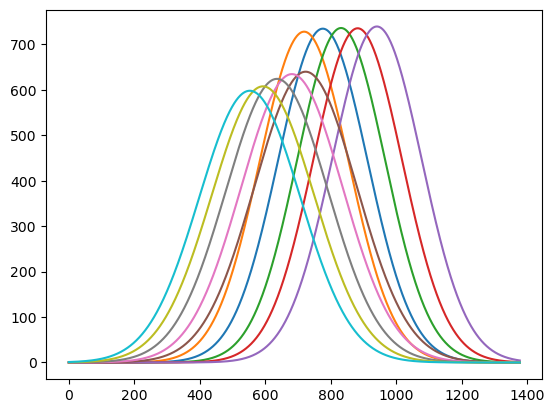

In [ ]:
for j in range(5):
    for i in range(5):
        plt.plot(corrected_vframe_container[j][i][774,:],list(mcolors.TABLEAU_COLORS)[i],marker='.',alpha=.1)

        plt.plot(gaussian(amplitude_contaner_h[5*j+i],waist_container_h[5*j+i],center_container_h[5*j+i],l_h))

[1.95970454e+00 3.20019583e-04]


Text(0, 0.5, 'w')

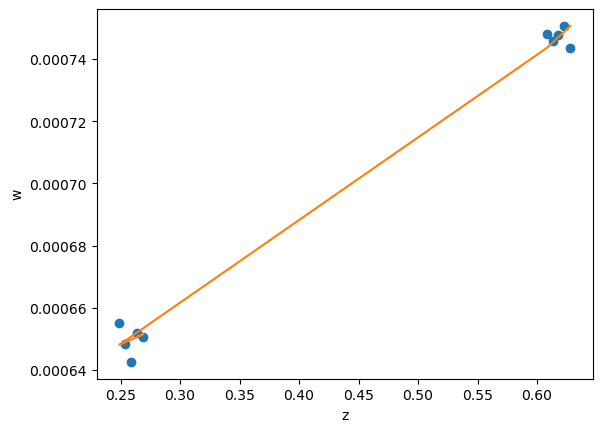

In [ ]:
target_waist_h = np.abs(waist_container_h)
p_0_waist_h = np.array([1,76e-6])
pfit_waist_h,pcov_waist_h = leastsq(waist_profile_residual,p_0_waist_h,args=(2.5-np.array(x_h),target_waist_h),full_output=1)[:2]
print(pfit_waist_h)
plt.plot(2.5-np.array(x_h),target_waist_h,'o')
plt.plot(2.5-np.array(x_h),waist_profile(*pfit_waist_h,2.5-np.array(x_h))) #[0]*np.ones(len(x)),pfit_waist[1]*np.ones(len(x))
plt.xlabel('z')
plt.ylabel('w')

[0.66669377 0.00306803]


Text(0, 0.5, 'w')

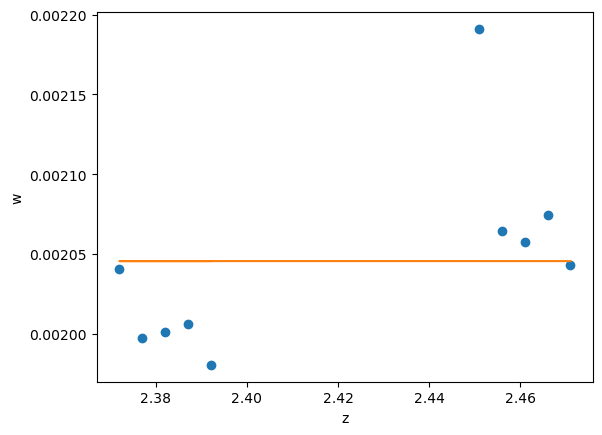

In [ ]:
target_waist_v = np.abs(waist_container_v)
p_0_waist_v = np.array([1,76e-6])
pfit_waist_v,pcov_waist_v = leastsq(waist_profile_residual,p_0_waist_v,args=(2.5-np.array(x_v),target_waist_v),full_output=1)[:2]
print(pfit_waist_v)
plt.plot(np.array(x_v),target_waist_v,'o')
plt.plot(np.array(x_v),waist_profile(*pfit_waist_v,2.5-np.array(x_v))) #[0]*np.ones(len(x)),pfit_waist[1]*np.ones(len(x))
plt.xlabel('z')
plt.ylabel('w')

Text(0, 0.5, 'integrated intensity')

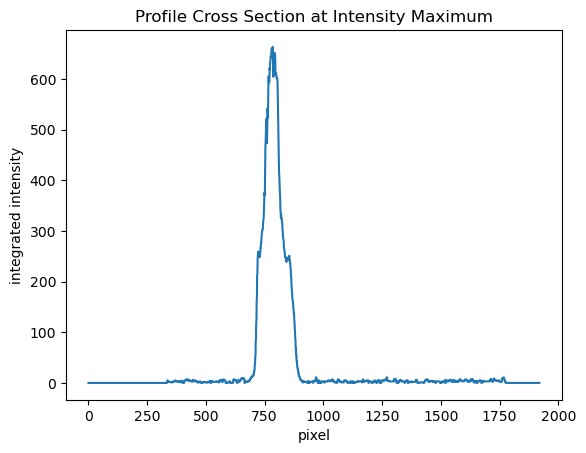

In [ ]:
plt.plot(np.sum(frame,axis=2)[798])
plt.title('Profile Cross Section at Intensity Maximum')
plt.xlabel('pixel')
plt.ylabel('integrated intensity')
#plt.savefig('profile_cross_section')

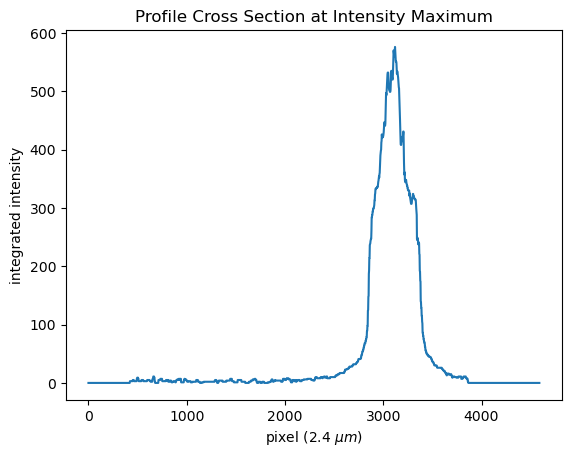

In [ ]:
plt.plot(np.arange(1913)*2.4,np.delete(np.sum(frame,axis=2)[213+7],[188+i for i in range(7)]))
plt.title('Profile Cross Section at Intensity Maximum')
plt.xlabel('pixel (2.4 $\mu m$)')
plt.ylabel('integrated intensity')
plt.savefig('profile_cross_section')